In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataloader - Flowers

Create a tensorflow dataloader using data argumentation.

1. Randomly corp 256x256 images around the middle
2. Flip the image / turn 90/180/270/360 degree
3. Change Brightness
4. Randomly Shuffle

In [ ]:
# divide image into its own category
%cd ~/flowers/
!mkdir jasmine
!mv white_flowers/01_*.png jasmine
!mkdir phlox
!mv white_flowers/02_*.png phlox
!mkdir leucan
!mv white_flowers/03_*.png leucan
!mkdir cherry
!mv white_flowers/04_*.png cherry
!mkdir viola
!mv white_flowers/05_*.png viola
!mkdir lily
!mv white_flowers/06_*.png lily
!mkdir appleTree
!mv white_flowers/07_*.png appleTree
!mkdir snowdrop
!mv white_flowers/08_*.png snowdrop
!mkdir perennial
!mv white_flowers/09_*.png perennial
!mkdir blackberry
!mv white_flowers/10_*.png blackberry
!mkdir strawberry
!mv white_flowers/11_*.png strawberry
!mkdir nankingcherry
!mv white_flowers/12_*.png nankingcherry
!mkdir bellflower
!mv white_flowers/13_*.png bellflower

/content/drive/MyDrive/MaskGIT/flowers
mkdir: cannot create directory ‘jasmine’: File exists
mv: cannot stat 'white_flowers/01_*.png': No such file or directory
mkdir: cannot create directory ‘phlox’: File exists
mv: cannot stat 'white_flowers/02_*.png': No such file or directory
mkdir: cannot create directory ‘leucan’: File exists
mv: cannot stat 'white_flowers/03_*.png': No such file or directory
mkdir: cannot create directory ‘cherry’: File exists
mv: cannot stat 'white_flowers/04_*.png': No such file or directory
mkdir: cannot create directory ‘viola’: File exists
mv: cannot stat 'white_flowers/05_*.png': No such file or directory
mkdir: cannot create directory ‘lily’: File exists
mv: cannot stat 'white_flowers/06_*.png': No such file or directory
mkdir: cannot create directory ‘appleTree’: File exists
mv: cannot stat 'white_flowers/07_*.png': No such file or directory
mkdir: cannot create directory ‘snowdrop’: File exists
mv: cannot stat 'white_flowers/08_*.png': No such file or d

In [3]:
%cd /content/drive/MyDrive/MaskGIT/checkpoints/
!unzip vqvae_ckpt_v1.zip

/content/drive/MyDrive/MaskGIT/checkpoints
Archive:  vqvae_ckpt_v1.zip
  inflating: vqvae_ckpt_v1/vqvae_epoch8  
  inflating: vqvae_ckpt_v1/vqvae_epoch12  
  inflating: vqvae_ckpt_v1/vqvae_epoch19  
  inflating: vqvae_ckpt_v1/vqvae_epoch0  
  inflating: vqvae_ckpt_v1/vqvae_epoch16  
  inflating: vqvae_ckpt_v1/vqvae_epoch4  


In [ ]:
%pip install opencv-python
%pip install jax==0.3.6

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import glob
import numpy as np
import random
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import albumentations

# load parameters
FLOWER_ROOT = '/home/bochao/flowers/'

categories = [
  'jasmine', 'phlox', 'leucan', 'cherry',
  'viola', 'lily', 'appleTree', 'snowdrop',
  'perennial', 'blackberry', 'strawberry', 'nankingcherry',
  'bellflower'
]
val_dir = 'val'

# Prevent tensorflow from using GPU
tf.config.experimental.set_visible_devices([], "GPU")

# try:
#   tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:
# Invalid device or cannot modify virtual devices once initialized.
#  pass
#!TF_GPU_ALLOCATOR=cuda_malloc_async

Data Augmentation: each image crop 256x256 around middle 3 times, and turn 90 degree 3 times, and flip 2 time, and change brightness 2 times.

In total, each image should generate 24 different images of size 256x256.

Input Image and Augmented 256x256 Images


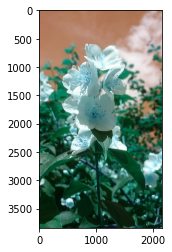

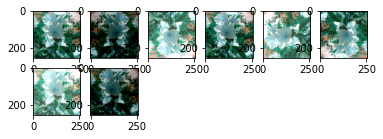

"\nfor c in categories:\n  imgs = glob.glob(FLOWER_ROOT + c + '/*.png')\n  for im in imgs:\n    augment(read_image(im), im_size=256)\n"

In [2]:
# read image and return a tensor whose value range from 0-1
def read_image(img_path):
  img = cv2.imread(img_path)
  img = tf.convert_to_tensor(img, dtype=tf.uint8)
  return tf.image.convert_image_dtype(img, tf.float32, saturate=False)

def random_brightness_clip(img, max_delta):
  return tf.clip_by_value(tf.image.random_brightness(img, max_delta), 0.0, 1.0)

# data augmentation
def augment(image, im_size):
  # middle point
  height, width, channel = image.shape
  mid_ht, mid_wt = height // 2, width // 2
  assert 256==im_size or 512==im_size
  crop_imgs = []
  # adjust these parameter to get better crop image
  move_offset = 256
  # crop_ht_size, crop_wt_size = height // 2, width // 2
  crop_size = min(height // 2, width // 2)
  image = tf.reshape(image, [1, height, width, channel])
  for i in range(3):
    # TODO: Overflow check here
    sp_ht, sp_wt = (mid_ht-crop_size//2+(i-1)*move_offset, mid_wt-crop_size//2+(i-1)*move_offset)
    box = [[sp_ht/height, sp_wt/width, (sp_ht+crop_size)/height, (sp_wt+crop_size)/width]]
    img = tf.image.crop_and_resize(image, box, box_indices=[0], crop_size=(im_size, im_size))
    img = tf.reshape(img, [im_size, im_size, channel])
    crop_imgs.append(img)
  image = tf.reshape(image, [height, width, channel])
  rotate_imgs = []
  for img in crop_imgs:
    # flip left right
    flip_lr_img = random_brightness_clip(tf.image.flip_left_right(img), max_delta=0.3)
    rotate_imgs.append(flip_lr_img)
    # flip upside down
    flip_ud_img = random_brightness_clip(tf.image.flip_up_down(img), max_delta=0.3)
    rotate_imgs.append(flip_ud_img)
    for i in range(3):
      # each crop_img rotate 90 degree 3 times
      rot_img = random_brightness_clip(tf.image.rot90(img, i), max_delta=0.3)
      rotate_imgs.append(rot_img)
  # adjust brightness deterministically
  dark_bright_imgs = []
  for img in crop_imgs:
    # brighter imgs
    dark_bright_imgs.append(tf.clip_by_value(tf.image.adjust_brightness(img, delta=0.25), 0.0, 1.0))
    # darker imgs
    dark_bright_imgs.append(tf.clip_by_value(tf.image.adjust_brightness(img, delta=-0.25), 0.0, 1.0))
  return crop_imgs + rotate_imgs + dark_bright_imgs

# New version of data augmentation
rescaler = albumentations.SmallestMaxSize(max_size=256)
cropper = albumentations.CenterCrop(height=256, width=256)
preprocessor = albumentations.Compose([rescaler, cropper])
def augment_v2(image, im_size):
    image = preprocessor(image=image.numpy())["image"]
    img = tf.image.convert_image_dtype(image, tf.float32, saturate=False)
    rotate_imgs = [img]
    # flip left right
    flip_lr_img = random_brightness_clip(tf.image.flip_left_right(img), max_delta=0.3)
    rotate_imgs.append(flip_lr_img)
    # flip upside down
    flip_ud_img = random_brightness_clip(tf.image.flip_up_down(img), max_delta=0.3)
    rotate_imgs.append(flip_ud_img)
    for i in range(3):
        # each crop_img rotate 90 degree 3 times
        rot_img = random_brightness_clip(tf.image.rot90(img, i), max_delta=0.3)
        rotate_imgs.append(rot_img)
    # adjust brightness deterministically
    dark_bright_imgs = []
    # brighter imgs
    dark_bright_imgs.append(tf.clip_by_value(tf.image.adjust_brightness(img, delta=0.25), 0.0, 1.0))
    # darker imgs
    dark_bright_imgs.append(tf.clip_by_value(tf.image.adjust_brightness(img, delta=-0.25), 0.0, 1.0))
    return rotate_imgs + dark_bright_imgs
    
    
# showing a bunch of augmented crop data
jasmine_imgs = glob.glob(FLOWER_ROOT+categories[0]+'/*.png')
i = random.randint(0, len(jasmine_imgs))
img = read_image(jasmine_imgs[i])
print("Input Image and Augmented 256x256 Images")
plt.imshow(img)
augmented_imgs = augment_v2(img, im_size=256)
# print(len(augmented_imgs))
fig = plt.figure()
for i in range(len(augmented_imgs)):
  ax = fig.add_subplot(4, 6, i+1)
  ax.imshow(tf.image.convert_image_dtype(augmented_imgs[i], tf.uint8))
plt.show()
# check if this method applied to all images
"""
for c in categories:
  imgs = glob.glob(FLOWER_ROOT + c + '/*.png')
  for im in imgs:
    augment(read_image(im), im_size=256)
"""

In [3]:
# data loader with augmentation
class FlowerDataloader(tf.keras.utils.Sequence): #
    def __init__(self, data_dir, batch_size, shuffle=True):
      self.train_imgs_path = []
      for dir in data_dir:
        imgs_path = glob.glob(dir + '/*.png')
        self.train_imgs_path += imgs_path
      self.train_imgs = []
      self.counter = 0
      self.num_imgs = len(self.train_imgs_path)
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.augment_factor = 8
      self.im_size = 256
      # self.__get_data()
      self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle == True:
            random.shuffle(self.train_imgs_path)
    
    def __len__(self):
        # Denotes the number of batches per epoch
        return np.ceil( self.augment_factor * self.num_imgs / self.batch_size).astype(int)

    def __getitem__(self, index):
        # Generate one batch of data
        while(len(self.train_imgs) < self.batch_size):
          img = read_image(self.train_imgs_path[self.counter])
          augmented = augment_v2(img, self.im_size)
          self.train_imgs += augmented
          self.counter = (self.counter+1) % self.num_imgs
        batch = self.train_imgs[0:self.batch_size]
        self.train_imgs = self.train_imgs[self.batch_size:]
        return batch

# Transfer Learning - VQGAN

Input training images and reconstruct using first stage of VQGAN:

1. Load MaskGIT github repo
2. Load MaskGIT Tokenizer checkpoint for ImageNet 256x256
3. Transfer Learning

## Preparation

In [5]:
# install required libraries
%pip install jax --user
%pip install flax
%pip install numpy tensorflow matplotlib ml_collections

     |████████████████████████████████| 184 kB 5.2 MB/s 
     |████████████████████████████████| 140 kB 36.4 MB/s 
     |████████████████████████████████| 72 kB 750 kB/s 
     |████████████████████████████████| 77 kB 3.4 MB/s 
     |████████████████████████████████| 462 kB 33.9 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=5e02e5633991b4b85778a4f360e854c3ebcb57da8ddb74df86479abca7b35b7f
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections


Download tokenizer and bidirectional transformer ImageNet 256x256 checkpoint

In [ ]:
%cd ~/checkpoints/
source_url = f'https://storage.googleapis.com/maskgit-public/checkpoints/tokenizer_imagenet256_checkpoint'
!wget {source_url} -O tokenizer_imagenet256_checkpoint
source_url = f'https://storage.googleapis.com/maskgit-public/checkpoints/maskgit_imagenet256_checkpoint'
!wget {source_url} -O maskgit_imagenet256_checkpoint

/home/bochao/checkpoints
--2022-04-14 04:08:05--  https://storage.googleapis.com/maskgit-public/checkpoints/tokenizer_imagenet256_checkpoint
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218068642 (208M) [application/octet-stream]
Saving to: ‘tokenizer_imagenet256_checkpoint’

tokenizer_imagenet2 100%[===================>] 207.97M  28.1MB/s    in 7.4s    

2022-04-14 04:08:13 (28.1 MB/s) - ‘tokenizer_imagenet256_checkpoint’ saved [218068642/218068642]

--2022-04-14 04:08:13--  https://storage.googleapis.com/maskgit-public/checkpoints/maskgit_imagenet256_checkpoint
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
H

In [6]:
# Dowload MaskGIT repo
%cd ~
!git clone https://github.com/google-research/maskgit.git
%cd maskgit
%ls

/root
Cloning into 'maskgit'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 29 (delta 3), reused 29 (delta 3), pack-reused 0
Unpacking objects: 100% (29/29), done.
/root/maskgit
CONTRIBUTING.md  LICENSE   MaskGIT_demo.ipynb  requirements.txt
imgs/            maskgit/  README.md


## Training

In [6]:
!nvidia-smi

Sun Apr 17 03:32:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%cd ~/maskgit
import jax
import jax.numpy as jnp
import flax
from flax import serialization
# from flax import optim
import optax
import itertools
from tqdm import tqdm

import maskgit
from maskgit.utils import visualize_images, read_image_from_url, restore_from_path, draw_image_with_bbox, Bbox
from maskgit.inference import ImageNet_class_conditional_generator
from maskgit.nets import vqgan_tokenizer, maskgit_transformer
from maskgit.configs import maskgit_class_cond_config
from maskgit.libml import losses, mask_schedule, parallel_decode

CKPT_PATH = '/home/bochao/checkpoints'
TOKENIZER_CKPT = 'tokenizer_imagenet256_checkpoint'
MASKGIT_CKPT = 'maskgit_imagenet256_checkpoint'
VQVAE_CKPT_ROOT = '/home/bochao/checkpoints/vqvae_ckpt_v1'
TRANSFORMER_CKPT_ROOT = '/home/bochao/checkpoints/transformer_ckpt_v1'

tokenizer_ckpt_path = os.path.join(CKPT_PATH, TOKENIZER_CKPT)
maskgit_ckpt_path = os.path.join(CKPT_PATH, MASKGIT_CKPT)
assert os.path.exists(tokenizer_ckpt_path)
assert os.path.exists(maskgit_ckpt_path)

print(jax.devices())
!pip show jaxlib

/home/bochao/maskgit
[GpuDevice(id=0, process_index=0)]
Name: jaxlib
Version: 0.3.5+cuda11.cudnn82
Summary: XLA library for JAX
Home-page: https://github.com/google/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: absl-py, flatbuffers, numpy, scipy
Required-by: chex, optax


Calculate train variance; needed for reconstruction loss

In [9]:
# compute train variance here
# sampling only the center crop images
def train_variance(train_dataset, im_size):
    imgs = []
    for img_path in train_dataset.train_imgs_path:
        im = read_image(img_path)
        height, width, channel = im.shape
        mid_ht, mid_wt = height // 2, width // 2
        crop_size = min(height // 2, width // 2)
        im = tf.reshape(im, [1, height, width, channel])
        sp_ht, sp_wt = (mid_ht-crop_size//2, mid_wt-crop_size//2)
        box = [[sp_ht/height, sp_wt/width, (sp_ht+crop_size)/height, (sp_wt+crop_size)/width]]
        img = tf.image.crop_and_resize(im, box, box_indices=[0], crop_size=(im_size, im_size))
        img = tf.reshape(img, [im_size, im_size, channel])
        imgs.append(img)
    # Reference: https://keras.io/examples/generative/vq_vae/
    return np.var(imgs), imgs[0:5]

In [ ]:
!nvidia-smi --gpu-reset
!nvidia-smi

Unable to disable persistence mode for GPU 00000000:00:04.0: Insufficient Permissions
Fri Apr 15 05:29:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |  14156MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
  

Fine-tuning the VQVAE on our dataset

In [10]:
# configurations
maskgit_cf = maskgit_class_cond_config.get_config()
maskgit_cf.image_size = 256
maskgit_cf.eval_batch_size = 8
epochs = 20
batch_size = 2

# Define tokenizer
tokenizer = vqgan_tokenizer.VQVAE(config=maskgit_cf, dtype=jnp.float32, train=True)

# Load checkpoint
tokenizer_variables = restore_from_path(tokenizer_ckpt_path)

# define optimizer
# CHECKME: Is this the correct optimizer parameters?
print(f'beta1:{maskgit_cf.optimizer.beta1}')
print(f'beta2:{maskgit_cf.optimizer.beta2}')
optimizer_def = optax.adam(learning_rate=0.0001, b1=maskgit_cf.optimizer.beta1, b2=maskgit_cf.optimizer.beta2)
optimizer = optimizer_def.init(tokenizer_variables)

# prepare train dataset
data_dir = []
for c in categories:
  path = os.path.join(FLOWER_ROOT, c)
  data_dir.append(path)
train_dataset = FlowerDataloader(data_dir, batch_size=batch_size)
print(len(train_dataset))

val_imgs = {}
# Compute train variance and select first five as val_imgs
# Expensive operation! Avoid invoking this!
# train_var, val_imgs['image'] = train_variance(train_dataset, im_size=256)
# print(f'Train variance: {train_var}')
train_var = 0.07519376277923584
val_imgs['image'] = []
for i in range(5):
    img_path = FLOWER_ROOT + val_dir + f'/{i}.png'
    img = read_image(img_path)
    val_imgs['image'].append(img)

def loss_fn(params, batch):
    input_dict = {
      'image':batch
    }
    # compute loss
    quantized, result_dict = tokenizer.apply(params, input_dict, method=tokenizer.encode, mutable=False)
    # decode
    reconstructed_imgs = tokenizer.apply(params, quantized, method=tokenizer.decode, mutable=False)
  
    # reconstruct loss: L2 norm between input and output
    reconstruct_loss = jnp.mean(jnp.power(jnp.subtract(jnp.array(input_dict['image']), reconstructed_imgs), 2)) / train_var
    # loss = reconstructed_loss + loss in result_dict
    loss = reconstruct_loss + result_dict['quantizer_loss']
    return loss


# @jax.jit
def train_step(params, opt_state, batch):
    grads = jax.grad(loss_fn)(params, batch)
    updates, opt_state = optimizer_def.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state


for epoch in range(epochs):
    with tqdm(range(len(train_dataset))) as pbar:
        for i, batch in zip(pbar, train_dataset):
            # Update
            tokenizer_variables, optimizer = train_step(tokenizer_variables, optimizer, jnp.array(batch))
            # pbar.set_postfix(loss=np.round(loss, 5))
            pbar.update(0)
    # validation & save
    if 0 == epoch % 4 or epoch == epochs-1:
        # compute loss
        quantized, result_dict = tokenizer.apply(tokenizer_variables, val_imgs, method=tokenizer.encode, mutable=False)
        # decode
        reconstructed_imgs = tokenizer.apply(tokenizer_variables, quantized, method=tokenizer.decode, mutable=False)
        # no gradient compute by just calling __call__ method
        val_imgs[f'epoch_{epoch}'] = reconstructed_imgs
        # save model
        save_path = os.path.join(VQVAE_CKPT_ROOT, f'vqvae_epoch{epoch}')
        with tf.io.gfile.GFile(save_path, mode='w+') as f:
            byte_ckpt = serialization.to_bytes(tokenizer_variables)
            f.write(byte_ckpt)

KeyboardInterrupt: ignored

Visualize Reconstruct Images

(1280, 256, 3)


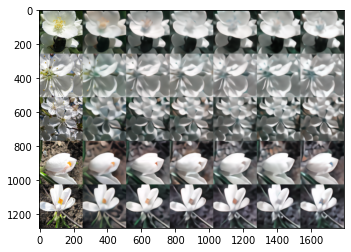

In [ ]:
"""
print(len(val_imgs['image']))
for i in range(len(val_imgs['image'])):
  np_img = tf.image.convert_image_dtype(val_imgs['image'][i], tf.uint8).numpy()
  img_path = FLOWER_ROOT + val_dir + f'/{i}.png'
  tf.keras.utils.save_img(img_path, x=np_img, data_format='channels_last')
"""
# Visualize the reconstructed image
# fig = plt.figure()
output_epoches = [0, 4, 8, 12, 16, 19]
res = []
res.append(tf.concat(val_imgs['image'], 0))
print(res[0].shape)
for i in range(len(output_epoches)):
    # key = 'image'
    key = f'epoch_{output_epoches[i]}'
    tmp = []
    for j in range(5):
        tmp.append(tf.clip_by_value(val_imgs[key][j], 0.0, 1.0))
    res.append(tf.concat(tmp, 0))

result_img = tf.image.convert_image_dtype(tf.concat(res, 1), tf.uint8).numpy()
plt.imshow(result_img)
tf.keras.utils.save_img('/home/bochao/results/reconstruct.png', x=result_img, data_format='channels_last')

# Transfer Learning - Bidirectional Transformer

For each type of flowers, we need to make them a label token. We need to train each type of flowers using MVTM introduced in the paper.

Transfer learning from Daisy!

In [ ]:
# Transfer learning from Daisy
maskgit_cf = maskgit_class_cond_config.get_config()
maskgit_cf.image_size = 256
maskgit_cf.eval_batch_size = 4
batch_size = 2
epochs = 100

# define tokenizer
transfer_learning_tokenizer_path = '/home/bochao/checkpoints/vqvae_ckpt_v1/vqvae_epoch0'
tokenizer = vqgan_tokenizer.VQVAE(config=maskgit_cf, dtype=jnp.float32, train=False)
# Load checkpoint
tokenizer_variables = restore_from_path(transfer_learning_tokenizer_path)

# define transformer
# vocab_size is composed of: 1024 tokens from vqvqe codebook + 1000 label token + 1 masked token
vocab_size = maskgit_cf.vqvae.codebook_size + maskgit_cf.num_class + 1
# each image is composed of: 1 label_token + 256 actual image tokens
transformer_block_size = 256 + 1
transformer = maskgit_transformer.Transformer(
    vocab_size=vocab_size,
    hidden_size=maskgit_cf.transformer.num_embeds,
    num_hidden_layers=maskgit_cf.transformer.num_layers,
    num_attention_heads=maskgit_cf.transformer.num_heads,
    intermediate_size=maskgit_cf.transformer.intermediate_size,
    hidden_dropout_prob=maskgit_cf.transformer.dropout_rate,
    attention_probs_dropout_prob=maskgit_cf.transformer.dropout_rate,
    max_position_embeddings=transformer_block_size
)
# load checkpoint
transformer_variables = restore_from_path(maskgit_ckpt_path)

# define optimizer
optimizer_def = optax.adam(
    learning_rate=maskgit_cf.optimizer.lr,
    b1=maskgit_cf.optimizer.beta1,
    b2=maskgit_cf.optimizer.beta2
)
optimizer = optimizer_def.init(transformer_variables)

# prepare dataset grouping by different categories
# categories = [
#  'jasmine', 'phlox', 'leucan', 'cherry',
#  'viola', 'lily', 'appleTree', 'snowdrop',
#  'perennial', 'blackberry', 'strawberry', 'nankingcherry',
#  'bellflower'
#]
train_category = 'jasmine'
train_dataset = FlowerDataloader([os.path.join(FLOWER_ROOT, train_category)], batch_size=batch_size)

# daisy 985
label_id = 985
generator_256 = ImageNet_class_conditional_generator(image_size=256)
# reset tokenizer
generator_256.tokenizer_variables = tokenizer_variables
generator_256.transformer_variables = transformer_variables

arbitrary_seed = 42
rng = jax.random.PRNGKey(arbitrary_seed)
generate_imgs = {}
loss_history = []

def transformer_loss_fn(params, batch):
    def tokens_to_logits(seq):
        # Applies a module method to variables and returns output and modified variables
        # if method not specified, invoke __call__ method
        logits = transformer.apply(params, seq, deterministic=True)
        # CHECKME: possibility of appearance for each tokens?
        logits = logits[..., :maskgit_cf.vqvae.codebook_size]
        return logits

    input_dict = {
        'image': batch
    }
    # tokenizer the image
    quantized, result_dict = tokenizer.apply(tokenizer_variables, input_dict, method=tokenizer.encode, mutable=False)
    # flatten
    encoding_indices = result_dict['encoding_indices'].reshape(batch_size, 256)
    
    # create class label_token
    label_tokens = label_id * jnp.ones([batch_size, 1])
    label_tokens = label_tokens + maskgit_cf.vqvae.codebook_size
    
    # create masked tokens
    # when training, do a uniform sampling
    mask_ratio = mask_schedule.schedule(ratio=np.random.uniform(0.0, 1.0), total_unknown=256) # TODO: IMPROVEMENT 1!
    mask_number = int(mask_ratio * 256)
    # force mask_number to be 1 to avoid zero-size array error
    if mask_number == 0:
        mask_number = 1
    mask_indices = np.random.choice(256, mask_number, replace=False)
    true_label = encoding_indices[:, mask_indices]
    encoding_indices = encoding_indices.at[:, mask_indices].set(maskgit_cf.transformer.mask_token_id)

    input_tokens = jnp.concatenate([label_tokens, encoding_indices], axis=-1)

    # predict tokens using transformer: calculate P(y_i | Y_{mask})
    pyi_ymask = tokens_to_logits(input_tokens)
    masked_pyi_ymask = pyi_ymask[:, mask_indices+1]

    # negative log-likelihood
    loss = losses.sequence_cross_entropy_loss(labels=true_label, logits=masked_pyi_ymask)
    return loss


# @jax.jit
def train_step(params, opt_state, batch):
    grads = jax.grad(transformer_loss_fn)(params, batch)
    updates, opt_state = optimizer_def.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state


for epoch in range(epochs):
    with tqdm(range(len(train_dataset))) as pbar:
        for i, batch in zip(pbar, train_dataset):
            # Update
            transformer_variables, optimizer = train_step(transformer_variables, optimizer, jnp.array(batch))
            # pbar.set_postfix(loss=np.round(loss, 5))
            pbar.update(0)
    # validation & save
    if 0 == epoch % 10 or epoch == epochs-1:
        # randomly generate a batch of image
        generator_256.transformer_variables = transformer_variables
        input_tokens = generator_256.create_input_tokens_normal(label_id)
        rng, sample_rng = jax.random.split(rng)
        results = generator_256.generate_samples(input_tokens, sample_rng)
        # output results
        tmp = []
        for j in range(maskgit_cf.eval_batch_size):
            tmp.append(tf.clip_by_value(results[j], 0.0, 1.0))
        results = tf.concat(tmp, 0)
        generate_imgs[f'epoch_{epoch}'] = results
        result_img = tf.image.convert_image_dtype(results, tf.uint8).numpy()
        tf.keras.utils.save_img(f'/home/bochao/results/generated_{train_category}_epoch_{epoch}.png', x=result_img, data_format='channels_last')
        
        # save model
        print('Save Model')
        save_path = os.path.join(TRANSFORMER_CKPT_ROOT, f'transformer_{train_category}_epoch{epoch}')
        with tf.io.gfile.GFile(save_path, mode='w+') as f:
            byte_ckpt = serialization.to_bytes(transformer_variables)
            f.write(byte_ckpt)

100%|█████████████████████████████████████████████████████| 200/200 [24:02<00:00,  7.21s/it]


Save Model


100%|█████████████████████████████████████████████████████| 200/200 [20:33<00:00,  6.17s/it]


Save Model


 72%|██████████████████████████████████████▍              | 145/200 [14:55<05:45,  6.29s/it]

Visualize images generated during the training

In [ ]:
# Visualize the reconstructed image
# fig = plt.figure()
output_epoches = [0, 4, 8, 12, 16, 19]
res = []
for i in range(len(output_epoches)):
    # key = 'image'
    key = f'epoch_{output_epoches[i]}'
    tmp = []
    for j in range(5):
        tmp.append(tf.clip_by_value(generate_imgs[key][j], 0.0, 1.0))
    res.append(tf.concat(tmp, 0))

result_img = tf.image.convert_image_dtype(tf.concat(res, 1), tf.uint8).numpy()
plt.imshow(result_img)
tf.keras.utils.save_img('/home/bochao/results/generated_imgs.png', x=result_img, data_format='channels_last')

# Evaluation Outputs